# Glacier Classifications. Convolutional Neural Network vs Fully Connected Neural Networtk
This notebook will show the performance of a Convolutional Naural Netwrok (CNN) agains a Fully Connected Neural Network (FCNN or NN) for image segmentation on glaciers. Sometimes we can not reside on satellite images and their spectral signatures to diferenciate glaciers from no-glacier objects, since sometimes there is non-snow material on top of glaciers and ice melanges at the side in contact with the sea. 
So basically, by using image (object) segmentation, the idea is to classify every pixel that might be part of glacier and non-glacier objects (binary category).

## Libraries to use
We import several libraries to use. Some of them are functions made by us, mostly for loading data from directories and doing the pre-processing on them (which something very important) and finally our CNN and NN models! Inside of them we also use libraries related to Georeferences Image processing. We are also using Keras from Tensorflow for the CNN and the NN. For other calculations as output interpretation, we are going to use Scikit-Learn for Confusion Matrix computations and other functions made by us. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import math as m
import rasterio as rt
from rasterio.plot import show as rtshow
from rasterio.merge import merge

#Libraries for Dense Neural Network and Machine Learning libraries for metrics
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from sklearn.metrics import confusion_matrix
#The above taken from Week 41, Morten's presentations
#Own created methods and functions.
from methods import Accuracy, encoder, decoder, data_load, pre_processing, data_augmentation, data_split, data_unit, train_test_split, plot_heatmap
from nn import U_Net

print('Libraries and packages imported.')

Libraries and packages imported.


# Convolutional Neural Network (U-Net Architecture)

## 1. Let's take a look at the data first
These are some examples of satellite images to use, extracted using Google Earth Engine platform (GEE). It comes from different places like Chile, Alaska and Svalbard, or the same place but in different times. We are using TOA (Top of Atmosphere) reflectance since images can be differente in spectral response based on where do they come from, daytime, satellite position, shadows, etc. This is a way to try to put them all as equal and is done by using the metadata of the files. All these has been done in GEE and the following code is just a visualizaiton. The first row are the original data, and the second one is with the GLIMS data (delineated glaciers by the scientific community).

loaded paths
data stacked
beginning figure


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


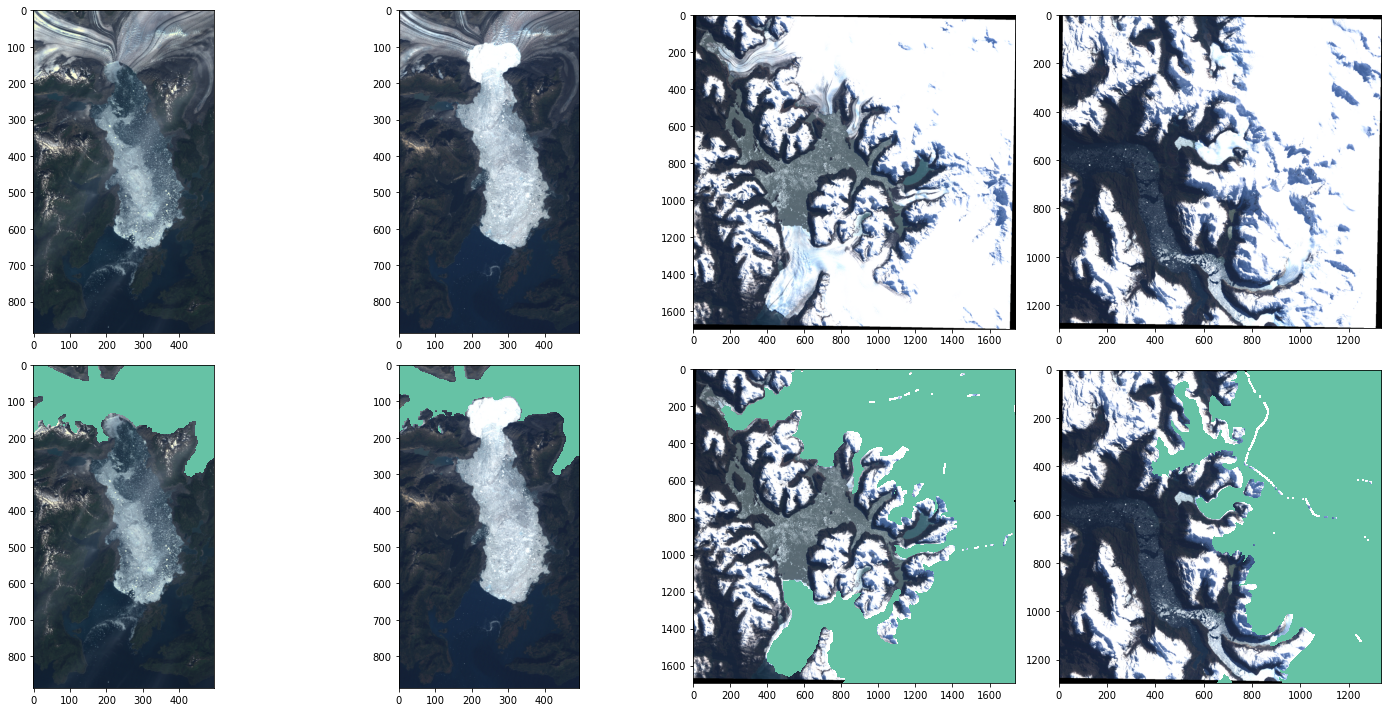

In [2]:
#DATA MANIPULATION FUNCTIONS!!
#dirs = np.sort([d for d in os.listdir('data/')])
dirs = np.sort(['2007_TOA', '2009_TOA', 'geometry', 'geometry2', 'geometry7', 'geometry8'])

#Just to know which band is which. This is useful for band operations to take out object indexes based on wavelength reflectance in the bands.
order = ['BLUE','GREEN','NIR','RED','SWIR']

#Some data monitoring visualization before and after Pre-process

lk1 = [r'data/2007_TOA/red.tif', r'data/2007_TOA/green.tif', r'data/2007_TOA/blue.tif', r'data/2007_TOA/glimsRast.tif']
lk2 = [r'data/2009_TOA/red.tif', r'data/2009_TOA/green.tif', r'data/2009_TOA/blue.tif', r'data/2009_TOA/glimsRast.tif']
lk3 = [r'data/geometry7/red.tif', r'data/geometry7/green.tif', r'data/geometry7/blue.tif', r'data/geometry7/glimsRast.tif']
lk4 = [r'data/geometry8/red.tif', r'data/geometry8/green.tif', r'data/geometry8/blue.tif', r'data/geometry8/glimsRast.tif']

print('loaded paths')

im1, gl1 = np.stack([rt.open(lk1[0]).read(1), rt.open(lk1[1]).read(1), rt.open(lk1[2]).read(1)], axis=2), rt.open(lk1[3]).read(1)
im2, gl2 = np.stack([rt.open(lk2[0]).read(1), rt.open(lk2[1]).read(1), rt.open(lk2[2]).read(1)], axis=2), rt.open(lk2[3]).read(1)
im3, gl3 = np.stack([rt.open(lk3[0]).read(1), rt.open(lk3[1]).read(1), rt.open(lk3[2]).read(1)], axis=2), rt.open(lk3[3]).read(1)
im4, gl4 = np.stack([rt.open(lk4[0]).read(1), rt.open(lk4[1]).read(1), rt.open(lk4[2]).read(1)], axis=2), rt.open(lk4[3]).read(1)

print('data stacked')

gl1[gl1 != 0.0] = 1
gl2[gl2 != 0.0] = 1
gl3[gl3 != 0.0] = 1
gl4[gl4 != 0.0] = 1

gl1 = np.ma.masked_where(gl1 == 0, gl1)
gl2 = np.ma.masked_where(gl2 == 0, gl2)
gl3 = np.ma.masked_where(gl3 == 0, gl3)
gl4 = np.ma.masked_where(gl4 == 0, gl4)

im1[np.isnan(im1)] = 0.0
im2[np.isnan(im2)] = 0.0
im3[np.isnan(im3)] = 0.0
im4[np.isnan(im4)] = 0.0

samples = [im1, im2, im3, im4]
glaciers = [gl1, gl2, gl3, gl4]

print('beginning figure')


fig, ax = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    if i < 4:
        ax[0,i].imshow(2*samples[i])
    else:
        ax[1,i-4].imshow(2*samples[i-4])
        ax[1,i-4].imshow(glaciers[i-4], cmap='Set2')
fig.tight_layout()
name = 'landsat_data.png'
plt.savefig('figures/'+name)

## 2. Pre-processing
This part is the most important since from this is that the code will learn how to difrferentiaite glacier from non-glacier objects. So the idea is to feed it with the most evidences ways to try to separate these objects. For this, here we compute a composite grayscale (Gray) of the normal colored images, a Normalized-Differenced Water Index (NDWI) and a Normalized-Difference Snow Index (NDSI). So instead of the RGB bands, we are going to pass Gray, NDWI and NDSI.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


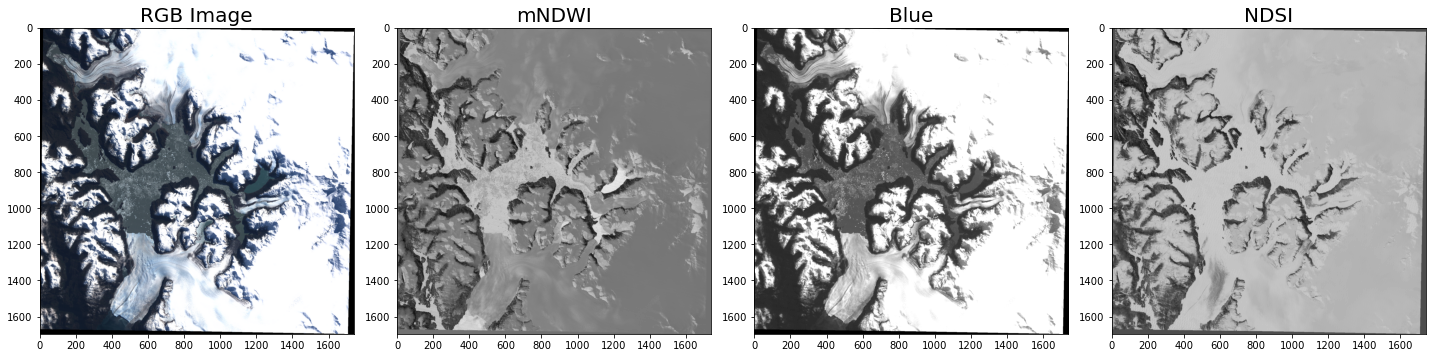

In [4]:
#Image of the pre_process and the new bands for input
im3_pro = pre_processing('data/geometry7', 2)

fig, ax = plt.subplots(1,4, figsize=(20,5))

ax[0].imshow(1.5*samples[2])
ax[0].set_title('RGB Image', fontsize=20)

ax[1].imshow(im3_pro[:,:,0], cmap='gray')
ax[1].set_title('mNDWI', fontsize=20)
ax[2].imshow(im3_pro[:,:,1], cmap='gray')
ax[2].set_title('Blue', fontsize=20)
ax[3].imshow(im3_pro[:,:,2], cmap='gray')
ax[3].set_title('NDSI', fontsize=20)

fig.tight_layout()
name = 'pre_processing.png'
plt.savefig('figures/'+name)

## 3. Data Augmentation.
Because we are poor and unfinanced (as far as we know), we do not have enough PC power (**Like a f@ck%ng Badass GPU memory**) to process big pictures as the satelitte images, and also, is not that all the glaciers have been delimited through time. So the best idea is to reduce the size without loosing resolution. That means, to cut the image in little pieces. Off course there might be a trading between the size of the images and the performance at predicting, since, the less the size, the less geometrical features we are avoiding. But if we increase it much then everything will be more PC expensive.
We hope that by far you realized that actually this concerns are mainly for the CNN, since this one is the only one able to regocnize patterns and geometries in the image, which is the main advantage in contrast to the NN.

By cutting them into pieces they still represent a little amount of data. So then let's create sinthetic data! We are taking the mini-images, reflect them and rotate them to create different patterns.

144.0 72.0 36.0
Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 504, Total test set: 0.


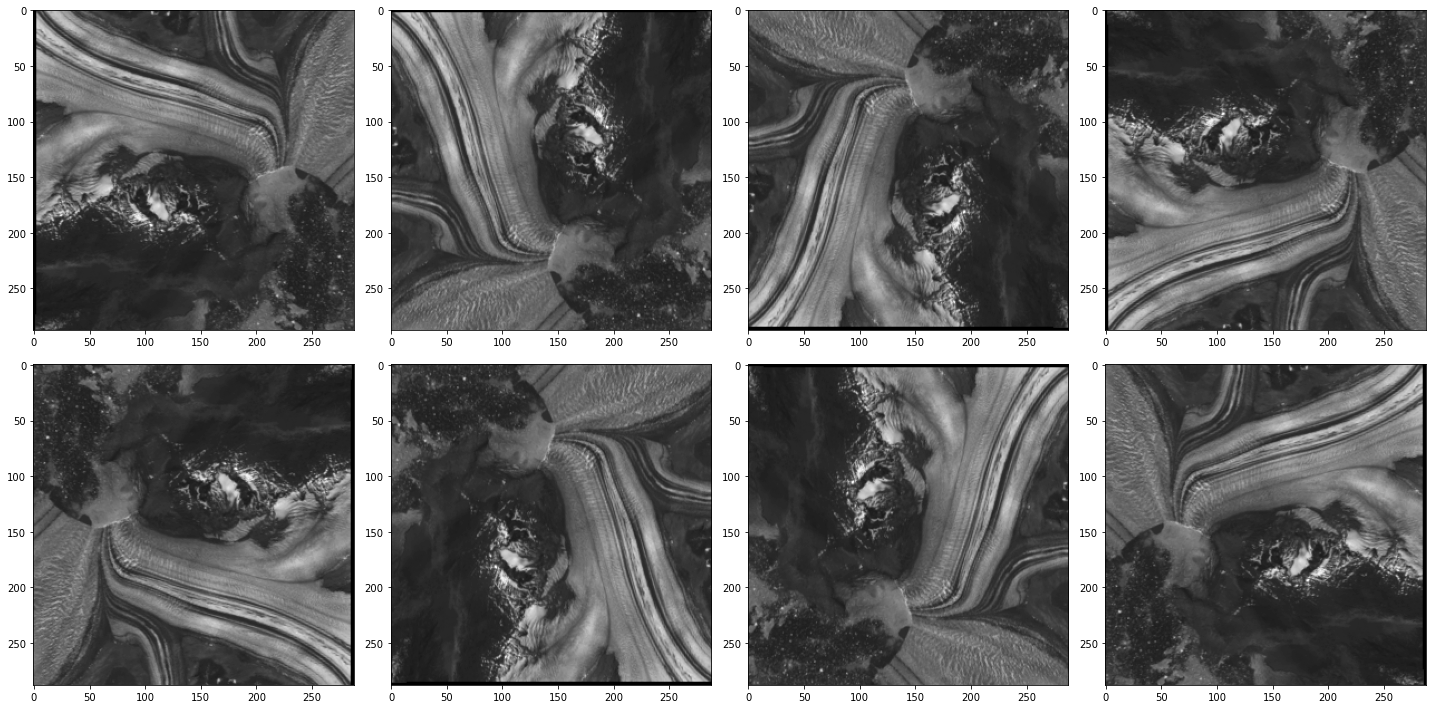

In [5]:
#Image for the Data Augmentation example
#192, 208, 
pix_division = 288
print(pix_division/2, pix_division/4, pix_division/8)

X_input, Y_input = data_load(dirs, pix_division, stack_axis=2)

uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')
#nX_train, nY_train, nX_test, nY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.2, type_is='nn')
#nY_train, nY_test = encoder(nY_train), encoder(nY_test)

fig, ax = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    if i < 4:
        ax[0,i].imshow(X_input[i,:,:,0], cmap='gray')
    else:
        ax[1,i-4].imshow(X_input[i,:,:,0], cmap='gray')
fig.tight_layout()
name = 'data_augmentation.png'
plt.savefig('figures/'+name)

## 4. Time to Train with the CNN!!
Here we are going to train the CNN, but this one is special. The achitecture of this CNN is asimilating the U-Net architecture used by Ronneberger et al. (2015) used for image segmentation of biomedical purposes. But here is for glaciers! The following part will separate train and test datasets. Here we use 0% for test since the model during the training will reserve 20% of the data for test performance. The loaded architecture will begin the training and there is going to be a plot of their performance (both train and test datasets). This is repeated for four differente image sizes to see the influence of the sizes.

Also lets just see after this how it classifies for two new unknown images with glaciers.

This might take a while, so run it and go an have fun. See you in... 12 hours, maybe? We don't know...

In [5]:
pixel_val = [96, 128, 288, 384]
versions = []

for i in range(len(pixel_val)):
    pix = pixel_val[i]
    X_input, Y_input = data_load(dirs, pix, stack_axis=2)
    uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 5680, Total test set: 0.
Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 3008, Total test set: 0.
Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 504, Total test set: 0.
Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 272, Total test set: 0.


Just see above the great amount of images that we managed to produce by cutting the original images by doing data augmentation in several sizes. Most of them produce way too much images for a normal PC to process with. It would take WAY TOO long!! Thhen for the big ones we might need to take a certain amount of them. What do you think about the first 1'000 images?

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 5680, Total test set: 0.
Progress for training for pixel size of 96
Progress finished for pixel size of 96
Appending model to list and plotting...


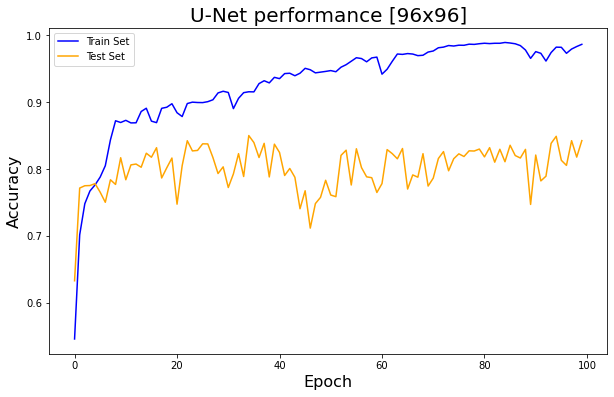

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 3008, Total test set: 0.
Progress for training for pixel size of 128
Progress finished for pixel size of 128
Appending model to list and plotting...


<Figure size 432x288 with 0 Axes>

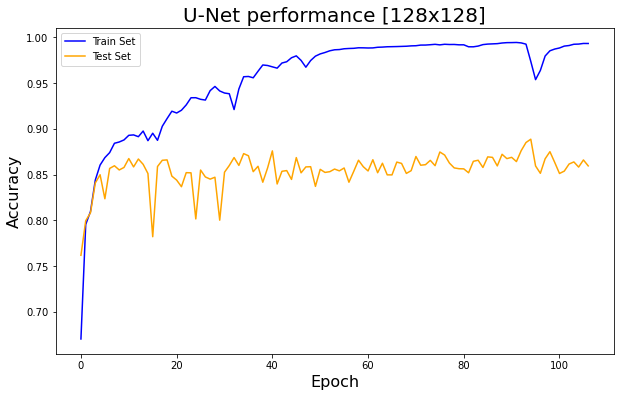

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 504, Total test set: 0.
Progress for training for pixel size of 288
Progress finished for pixel size of 288
Appending model to list and plotting...


<Figure size 432x288 with 0 Axes>

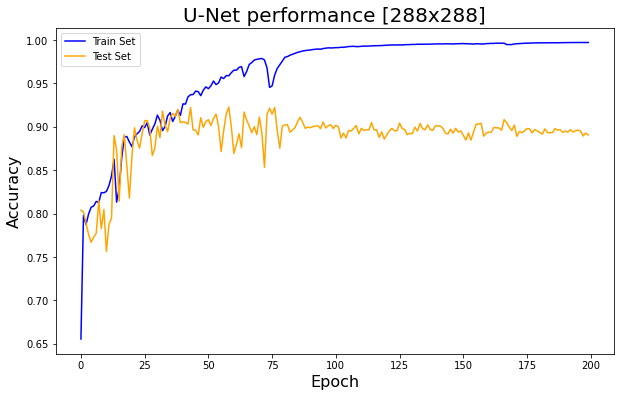

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 272, Total test set: 0.
Progress for training for pixel size of 384
Progress finished for pixel size of 384
Appending model to list and plotting...


<Figure size 432x288 with 0 Axes>

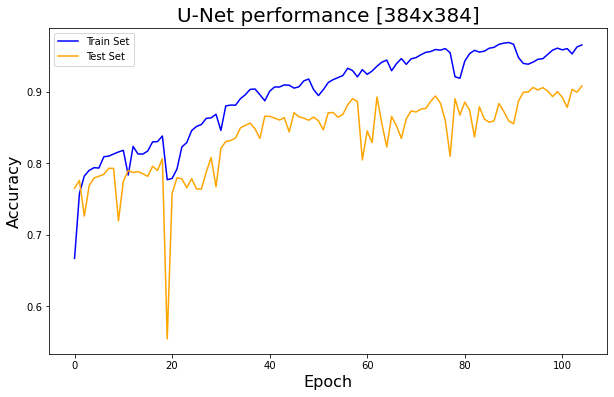

<Figure size 432x288 with 0 Axes>

In [6]:
#Lets try to see what happens when pixel values are changed. We are going to plot performance and with test data from other parts.

pixel_val = [96, 128, 288, 384]
versions = []

for i in range(len(pixel_val)):
    pix = pixel_val[i]
    X_input, Y_input = data_load(dirs, pix, stack_axis=2)
    uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')
    
    #Cut the data for the first two pixel size values, because then it will take WAY TOO MUCH for a normal PC.
    if i < 2:
        uX_train, uY_train = uX_train[:600], uY_train[:600]
        
    if i >= 2:
        uX_train, uY_train = uX_train[:200], uY_train[:200]
    
    U = U_Net(X_input=uX_train, Y_input=uY_train, batch_size=None, learning_rate=None, epochs=200, act_type='relu', out_act_type='sigmoid', penalty=0.0)
    #U.summary()
    print('Progress for training for pixel size of '+str(pix))
    results = U.train(verbose_opt=0)
    print('Progress finished for pixel size of '+str(pix))
    print('Appending model to list and plotting...')
    
    versions.append(U)
    
    plt.figure(figsize=(10,6))
    plt.plot(results.history['accuracy'], c='blue', label='Train Set')
    plt.plot(results.history['val_accuracy'], c='orange', label='Test Set')
    plt.title('U-Net performance ['+str(pix)+'x'+str(pix)+']', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend()
    plt.show()
    name = 'Unet_adam_'+str(pix)+'div.png'
    plt.savefig('figures/'+name)

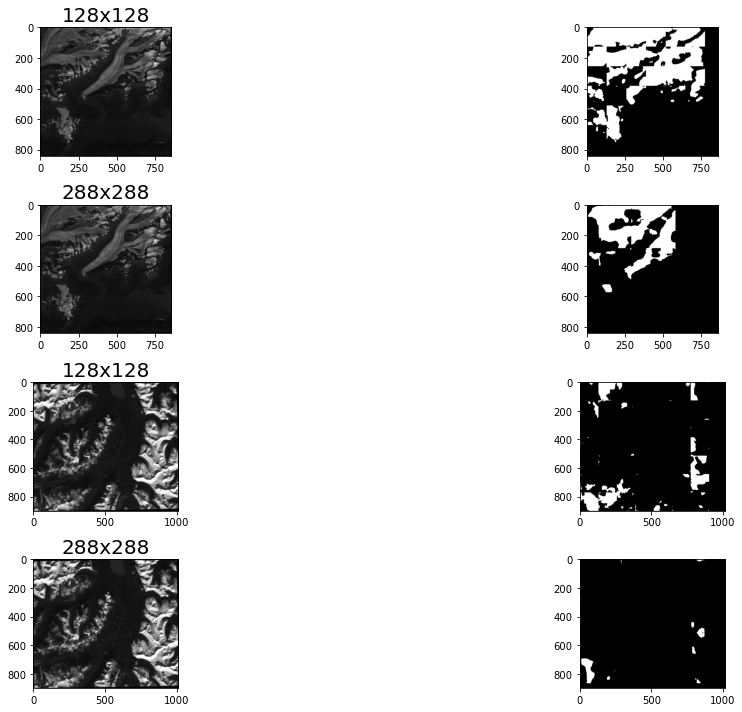

In [8]:
#Lets now visualize real unknown targets that we don't have solution to, and were not used in the training process and lets see the output images.
pixel_val = [128,288] #This doesn't go here
#versions = versions[[1,2]] 
#versions = [] #Dis not
#Thsi already made, take out!

#for i in range(len(pixel_val)):
#    pix = pixel_val[i]
#    X_input, Y_input = data_load(dirs, pix, stack_axis=2)
#    uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')
#    
#    #Cut the data for the first two pixel size values, because then it will take WAY TOO MUCH for a normal PC.
#    if i == 0:
#        uX_train, uY_train = uX_train[:600], uY_train[:600]
#        
#    if i == 1:
#        uX_train, uY_train = uX_train[:200], uY_train[:200]
#    
#    U = U_Net(X_input=uX_train, Y_input=uY_train, batch_size=None, learning_rate=None, epochs=90, act_type='relu', out_act_type='sigmoid', penalty=0.0)
#    
#    results = U.train(verbose_opt=0)
#    versions.append(U)
    
    

fig, ax = plt.subplots(4,2, figsize=(20,10))
    
for i in range(len(versions)):
    pix = pixel_val[i]
    
    or_data1 = pre_processing('data/geometry4', 2)
    dtest1, test_dim1 = data_split(or_data1, pix)
    dtest1 = versions[i].predict(dtest1)

    or_test1 = data_unit(dtest1, test_dim1)
    th = 0.5
    or_test1[or_test1 < th] = 0.0
    or_test1[or_test1 >= th] = 1.0
    
    or_data2 = pre_processing('data/geometry3', 2)
    dtest2, test_dim2 = data_split(or_data2, pix)
    dtest2 = versions[i].predict(dtest2)

    or_test2 = data_unit(dtest2, test_dim2)
    th = 0.5
    or_test2[or_test2 < th] = 0.0
    or_test2[or_test2 >= th] = 1.0

    #ax[0,i].imshow(or_data[:,:,0], cmap='gray')
    #ax[0,i].set_title(str(pix)+'x'+str(pix), fontsize=20)
    #ax[1,i].imshow(or_test, cmap='gray')
    
    ax[i,0].imshow(or_data1[:,:,0], cmap='gray')
    ax[i,0].set_title(str(pix)+'x'+str(pix), fontsize=20)
    ax[i,1].imshow(or_test1, cmap='gray')
    
    ax[i+2,0].imshow(or_data2[:,:,0], cmap='gray')
    ax[i+2,0].set_title(str(pix)+'x'+str(pix), fontsize=20)
    ax[i+2,1].imshow(or_test2, cmap='gray')

fig.tight_layout()
name = 'div_outs_geometry.png'
plt.savefig('figures/'+name)


#fig, ax = plt.subplots(2,1, figsize=(20,10))
#    
#for i in range(len(versions)):
#    pix = pixel_val[j]
#    
#    or_data2 = pre_processing('data/geometry3', 2)
#    dtest2, test_dim2 = data_split(or_data2, pix)
#    dtest2 = versions[i].predict(dtest2)
#
#    or_test2 = data_unit(dtest2, test_dim2)
#    th = 0.5
#    or_test2[or_test2 < th] = 0.0
#    or_test2[or_test2 >= th] = 1.0
#
#    #ax[0,i].imshow(or_data[:,:,0], cmap='gray')
#    #ax[0,i].set_title(str(pix)+'x'+str(pix), fontsize=20)
#    #ax[1,i].imshow(or_test, cmap='gray')
#    
#    ax[i+2,0].imshow(or_data2[:,:,0], cmap='gray')
#    ax[i+2,0].set_title(str(pix)+'x'+str(pix), fontsize=20)
#    ax[i+2,1].imshow(or_test2, cmap='gray')
#
#fig.tight_layout()
#name = 'div_outs_geometry3.png'
#plt.savefig('figures/'+name)

## 5. Let's explore some Activation Functions.
Activation functions inside the layers can also affect performance, and for every casy, an specific activation function could be the ideal. Normally for image segmentation, ReLU works like a charm. But just to justify our election, lets see what happens when we play with that parameter.

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 3008, Total test set: 0.
Progress for training for activation function: leaky_relu
Progress finished for activation function: leaky_relu
Appending performances to lists for plotting...
Progress for training for activation function: relu
Progress finished for activation function: relu
Appending performances to lists for plotting...
Progress for training for activation function: sigmoid
Progress finished for activation function: sigmoid
Appending performances to lists for plotting...
Progress for training for activation function: tanh
Progress finished for activation function: tanh
Appending performances to lists for plotting...


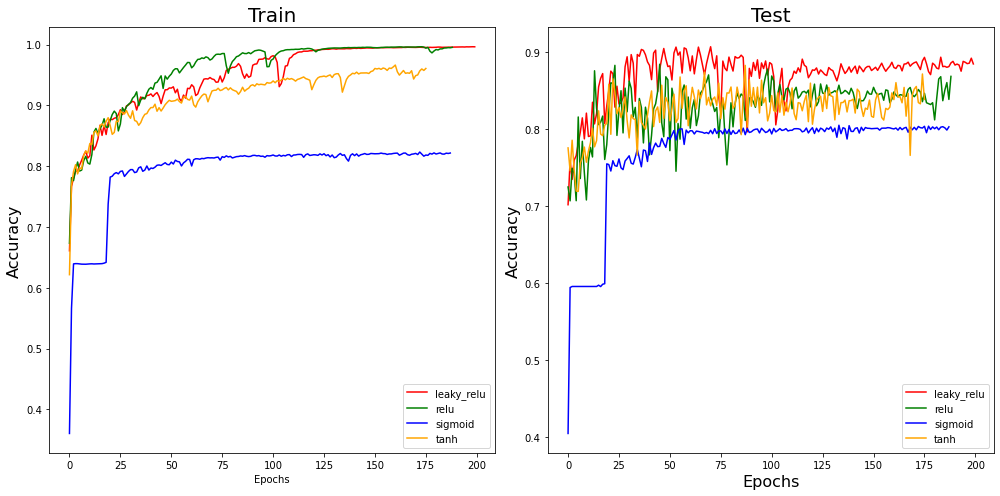

In [17]:
activations = ['leaky_relu', 'relu', 'sigmoid', 'tanh']
colors = ['red', 'green', 'blue', 'orange']
trains = []
tests = []
pix = 128
X_input, Y_input = data_load(dirs, pix, stack_axis=2)
uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')
uX_train, uY_train = uX_train[:300], uY_train[:300]

for i in range(len(activations)):
    act_func = activations[i]
    U = U_Net(X_input=uX_train, Y_input=uY_train, batch_size=None, learning_rate=None, epochs=200, act_type=act_func, out_act_type='sigmoid', penalty=0.0)
    #U.summary()
    print('Progress for training for activation function: '+act_func)
    results = U.train(verbose_opt=0)
    print('Progress finished for activation function: '+act_func)
    print('Appending performances to lists for plotting...')
    
    trains.append(results.history['accuracy'])
    tests.append(results.history['val_accuracy'])
    
#Plotting the results

fig, ax = plt.subplots(1,2, figsize=(14,7))

for i in range(len(colors)):
    ax[0].plot(trains[i], c=colors[i], label=activations[i])
    ax[1].plot(tests[i], c=colors[i], label=activations[i])
    
ax[0].set_title('Train', fontsize=20)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].set_title('Test', fontsize=20)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].legend()

fig.tight_layout()
name = 'Unet_act_variations.png'
plt.savefig('figures/'+name)

## 6. What if we change the optimizers?
For now we have been using Adam as the default optimizer of this CNN. What if we now use an old one from previous work, the Stochastic Gradient Descent? Off course it will depend on the learning rate to be choosen, so we might need also to explore this trade-off to see which learning rate works the best for this model.

In [ ]:
learning_rates = np.logspace(0.01, 0.15, 10)
trains = []
tests = []
epochs = list(range(0,110,10))

for i in range(len(learning_rates)):
    lr = learning_rates[i]
    U = U_Net(X_input=uX_train, Y_input=uY_train, batch_size=None, learning_rate=lr, epochs=int(epochs), act_type='relu', out_act_type='sigmoid', penalty=0.0)
    #U.summary()
    print('Progress for training with learning rate of: '+str(lr))
    results = U.train(verbose_opt=0)
    print('Progress finished for activation function: '+str(lr))
    print('Appending performances to lists for plotting...')
    
    train_res = np.array(resultsNN.history['accuracy'])
    test_res = np.array(resultsNN.history['val_accuracy'])
    
    trains.append(train_res[epochs])
    tests.append(test_res[epochs])
    
#Plotting the results

trains = np.array(trains)
tests = np.array(tests)
epochs = np.array(epochs)
    
title = 'Learning Rate Vs. Epochs (Train)'
ylabel = 'Epochs'
xlabel = 'Learning Rate'
plot_heatmap(trains, title, xlabel, ylabel, x_values=np.round(learning_rates,4), y_values=epochs, x_rot=False, log_scale=False, fig_name='Unet_lr_var_train.png')

title = 'Learning Rate Vs. Epochs (Test)'
ylabel = 'Epochs'
xlabel = 'Learning Rate'
plot_heatmap(tests, title, xlabel, ylabel, x_values=np.round(learning_rates,4), y_values=epochs, x_rot=False, log_scale=False, fig_name='Unet_lr_var_test.png')

In [ ]:
#TESTING!!
pix = 288
epochs = 125

X_input, Y_input = data_load(dirs, pix, stack_axis=2)
uX_train, uY_train, uX_test, uY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='unet')
uX_train, uY_train = uX_train[:200], uY_train[:200]

U = U_Net(X_input=uX_train, Y_input=uY_train, batch_size=None, learning_rate=None, epochs=int(epochs), act_type='relu', out_act_type='sigmoid', penalty=0.0)
#U.summary()
U.train(verbose_opt=0)

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 504, Total test set: 0.


(887, 495, 5)
[887, 495, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(864, 288)
(864, 288)
(887, 495, 5)
[887, 495, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(864, 288)
(864, 288)
(1696, 1740, 5)
[1696, 1740, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1440, 1728)
(1440, 1728)
(1297, 1333, 5)
[1297, 1333, 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1152, 1152)
(1152, 1152)


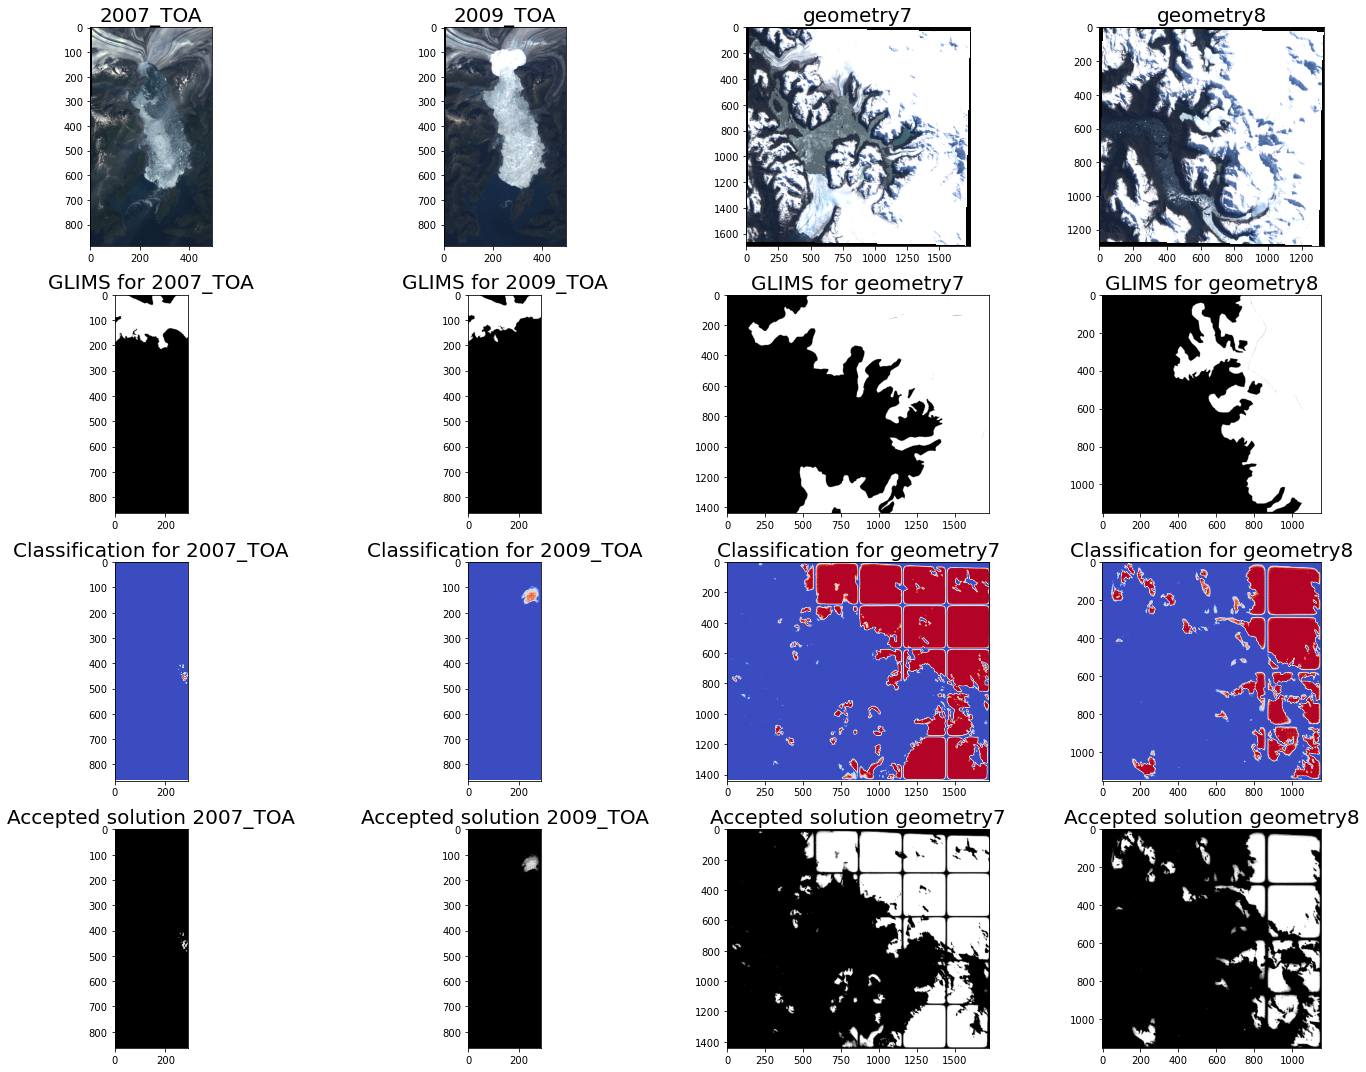

In [40]:
dirc = ['2007_TOA','2009_TOA','geometry7','geometry8']
thres = 0.5
pix = 288

fig, ax = plt.subplots(4,4, figsize=(15,20))

for i in range(4):
    lk = [r'data/'+dirc[i]+'/red.tif', r'data/'+dirc[i]+'/green.tif', r'data/'+dirc[i]+'/blue.tif', r'data/'+dirc[i]+'/glimsRast.tif']
    original = np.stack([rt.open(lk[0]).read(1), rt.open(lk[1]).read(1), rt.open(lk[2]).read(1)], axis=2)
    
    sample = pre_processing(r'data/'+dirc[i], stack_axis=2)
    sample, sample_dim = data_split(sample, pix)
    or_h, or_w = sample_dim[0], sample_dim[1]
    r_h, r_w = int(int(or_h/pix)*pix), int(int(or_w/pix)*pix)
    result = U.predict(sample)
    
    accepted = result
    accepted[accepted >= thres] = 1.0
    accepted[accepted < thres] = 0.0
    a_shape = accepted.shape
    
    target = rt.open(lk[3]).read(1)
    target = target[:r_h,:r_w]
    target[target !=0.0] = 1.0
    t_shape = target.shape
    
    result = data_unit(result, sample_dim)[:r_h,:r_w,0]
    accepted = data_unit(accepted, sample_dim)[:r_h,:r_w,0]
    
    diff = target - accepted
    
    
    ax[0,i].imshow(2*original)
    ax[0,i].set_title(dirc[i], fontsize=20)
    ax[1,i].imshow(target, cmap='gray')
    ax[1,i].set_title('GLIMS for '+dirc[i], fontsize=20)
    ax[2,i].imshow(result, cmap='coolwarm')
    ax[2,i].set_title('Glacier Probability '+dirc[i], fontsize=20)
    #ax[2,i].colorbar()
    ax[3,i].imshow(accepted, cmap='gray')
    ax[3,i].set_title('Glacier Probability '+dirc[i], fontsize=20)
    ax[3,i].imshow(accepted, cmap='gray')
    ax[3,i].set_title('Accepted solution '+dirc[i], fontsize=20)
    #print(poli)
    
fig.tight_layout()
name = 'Unet_predictions_sol.png'
plt.savefig('figures/'+name)

In [ ]:
dirc = ['geometry3','geometry4']
thres = 0.5
pix = 288

fig, ax = plt.subplots(3,2, figsize=(15,20))

for i in range(4):
    lk = [r'data/'+dirc[i]+'/red.tif', r'data/'+dirc[i]+'/green.tif', r'data/'+dirc[i]+'/blue.tif']
    original = np.stack([rt.open(lk[0]).read(1), rt.open(lk[1]).read(1), rt.open(lk[2]).read(1)], axis=2)
    
    sample = pre_processing(r'data/'+dirc[i], stack_axis=2)
    sample, sample_dim = data_split(sample, pix)
    or_h, or_w = sample_dim[0], sample_dim[1]
    r_h, r_w = int(int(or_h/pix)*pix), int(int(or_w/pix)*pix)
    result = U.predict(sample)
    
    accepted = result
    accepted[accepted >= thres] = 1.0
    accepted[accepted < thres] = 0.0
    a_shape = accepted.shape
    
    target = rt.open(lk[3]).read(1)
    target = target[:r_h,:r_w]
    target[target !=0.0] = 1.0
    t_shape = target.shape
    
    result = data_unit(result, sample_dim)[:r_h,:r_w,0]
    accepted = data_unit(accepted, sample_dim)[:r_h,:r_w,0]
    
    
    ax[0,i].imshow(2*original)
    ax[0,i].set_title(dirc[i], fontsize=20)
    ax[1,i].imshow(result, cmap='coolwarm')
    ax[1,i].set_title('Glacier Probability '+dirc[i], fontsize=20)
    #ax[2,i].colorbar()
    ax[1,i].imshow(accepted, cmap='gray')
    ax[1,i].set_title('Accepted solution '+dirc[i], fontsize=20)
    #print(poli)
    
fig.tight_layout()
name = 'Unet_predictions_NONEsol.png'
plt.savefig('figures/'+name)

# Feed Forward (Fully Connected) Neural Network

## 1. Behold the NN architecture!
I now, after seeing the CNN, the following is not so amazing, but guess we must try to see how it performs now with this one. The main idea is to see the advantages of one of them in comparison to the other. The following cell is an easy way (Thanks to Keras) of how to build a simple Feed Forward Neural Network (FFNN or NN). If you want to know how to build a proper one by yourself, you can check the NeuralNetwork class inside the *nn.py* file. We just want to go for the most assuring method, so that's why we relly on Keras for this one also.

Also we are just going to load the data for this particular problem of NN. Here the geometries and patterns inside the image is not considered, but mostly pixel-wise values.

In [5]:
#Function for initializing the Keras Neural Network (TensorFlow).
#Inputs:
    #- Variables for initializing the neural netwrok such as hidden layers, categories, regularization parameters, activation function, probability calculation at the end, learning rate.
#Outputs:
    #- A Sequential network class initialized with the specifications.
def Keras_NN(hidden_layers, out_layer, learning, regul=0.0, act_func='relu', proba=True):
    net = Sequential()
    for item in hidden_layers:
        net.add(Dense(item, activation=act_func, kernel_regularizer=regularizers.l2(regul)))
    if proba == True:
        net.add(Dense(out_layer, activation='softmax'))
    else:
        net.add(Dense(out_layer, activation='linear'))
    sgd = optimizers.SGD(lr=learning)
    net.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return net

In [53]:
nX_train, nY_train, nX_test, nY_test = train_test_split(X_input, Y_input, shuffle=True, test_perc = 0.0, type_is='nn')
nX_train, nY_train = nX_train[:3500], encoder(nY_train[:3500])

Preparing Train and Test splitting...
Train and Test splitting done. Total trian set: 41803776, Total test set: 0.


## 2. Which is the best Learning Rate?
Now that the FFNN or NN is defined, we can initialized easily with different parameters. Since this works by default with SGD, we can begin to first see the behavior against several learning rates. 

Beginning training with a learning rate of: 0.00031622776601683794
Beginning training with a learning rate of: 0.0009261187281287938
Beginning training with a learning rate of: 0.0027122725793320298
Beginning training with a learning rate of: 0.007943282347242814
Beginning training with a learning rate of: 0.02326305067153626
Beginning training with a learning rate of: 0.06812920690579616
Beginning training with a learning rate of: 0.1995262314968879
Beginning training with a learning rate of: 0.5843414133735175
Beginning training with a learning rate of: 1.711328304161781
Beginning training with a learning rate of: 5.011872336272722


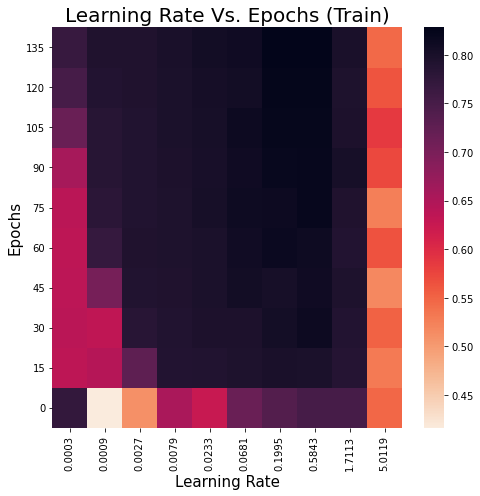

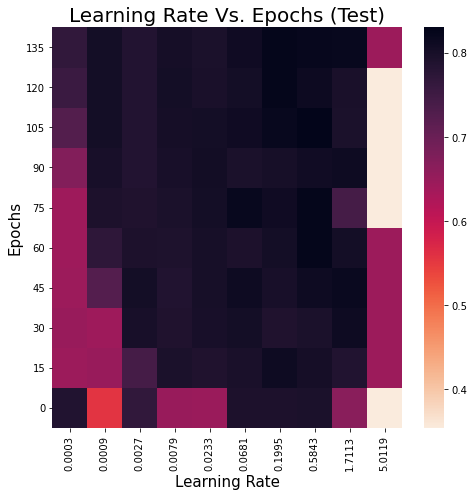

In [54]:
learning_rates = np.logspace(-3.5, 0.7, 10)
trains = []
tests = []
epochs = list(range(0,140,15))

for i in range(len(learning_rates)):
    lr = learning_rates[i]
    print('Beginning training with a learning rate of: '+str(lr))
    neural = Keras_NN(hidden_layers=[120], out_layer=2, learning=lr, regul=0.0, act_func='relu', proba=True)
    resultsNN = neural.fit(nX_train, nY_train, epochs=140, verbose=0, validation_split=0.2, shuffle=True)
    train_res = np.array(resultsNN.history['accuracy'])
    test_res = np.array(resultsNN.history['val_accuracy'])
    trains.append(train_res[epochs])
    tests.append(test_res[epochs])
    
trains = np.array(trains)
tests = np.array(tests)
epochs = np.array(epochs)
    
title = 'Learning Rate Vs. Epochs (Train)'
ylabel = 'Epochs'
xlabel = 'Learning Rate'
plot_heatmap(trains, title, xlabel, ylabel, x_values=np.round(learning_rates,4), y_values=epochs, x_rot=False, log_scale=False, fig_name='NN_lr_var_train.png')

title = 'Learning Rate Vs. Epochs (Test)'
ylabel = 'Epochs'
xlabel = 'Learning Rate'
plot_heatmap(tests, title, xlabel, ylabel, x_values=np.round(learning_rates,4), y_values=epochs, x_rot=False, log_scale=False, fig_name='NN_lr_var_test.png')

## 3. Lets see some effects of Activation Functions

Now we know that the best learning rates ranged from 0.0027 to 1.7133. Lets take 0.3 as the best one that is from the center, kind of. Now we must see which activation functions works the best.

Beginning training with activation function = linear
Beginning training with activation function = relu
Beginning training with activation function = sigmoid
Beginning training with activation function = tanh


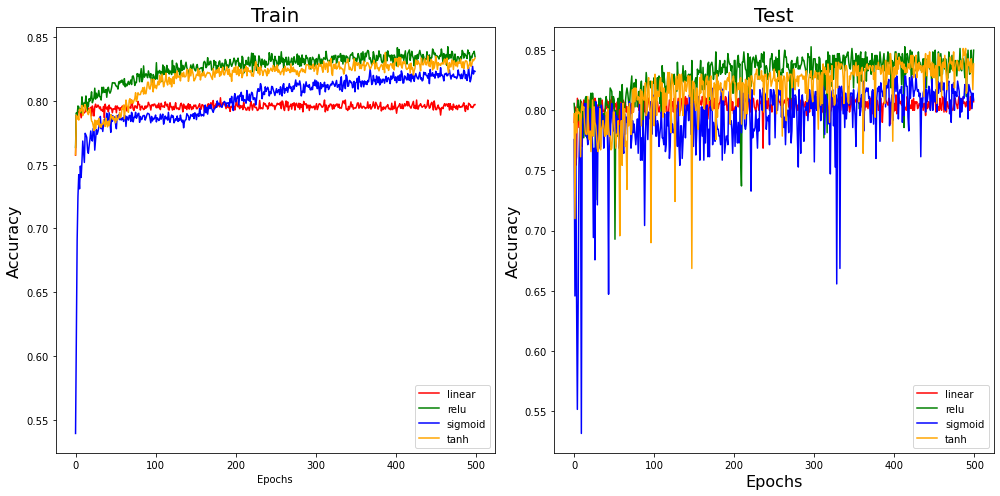

In [69]:
activations = ['linear', 'relu', 'sigmoid', 'tanh']
colors = ['red', 'green', 'blue', 'orange']
trains = []
tests = []
epochs = list(range(0,140,15))

for i in range(len(activations)):
    act_func = activations[i]
    print('Beginning training with activation function = '+act_func)
    neural = Keras_NN(hidden_layers=[120], out_layer=2, learning=0.3, regul=0.0, act_func=act_func, proba=True)
    resultsNN = neural.fit(nX_train, nY_train, epochs=500, verbose=0, validation_split=0.2, shuffle=True)
    train_res = np.array(resultsNN.history['accuracy'])
    test_res = np.array(resultsNN.history['val_accuracy'])
    trains.append(train_res)
    tests.append(test_res)
    
trains = np.array(trains)
tests = np.array(tests)
    
#Plotting the results
fig, ax = plt.subplots(1,2, figsize=(14,7))

for i in range(len(colors)):
    ax[0].plot(trains[i], c=colors[i], label=activations[i])
    ax[1].plot(tests[i], c=colors[i], label=activations[i])
    
ax[0].set_title('Train', fontsize=20)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].set_title('Test', fontsize=20)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].legend()

fig.tight_layout()
name = 'NN_act_variations.png'
plt.savefig('figures/'+name)

## 4. Penalty Parameters

Sometimes when certain weights inside a network are a problem, we use penalty values to try to decrease them. Here we are going to study several penlaty parameters to see how this graphs changes.

Beginning training with a penalty of: 0.00031622776601683794
Beginning training with a penalty of: 0.0009261187281287938
Beginning training with a penalty of: 0.0027122725793320298
Beginning training with a penalty of: 0.007943282347242814
Beginning training with a penalty of: 0.02326305067153626
Beginning training with a penalty of: 0.06812920690579616
Beginning training with a penalty of: 0.1995262314968879
Beginning training with a penalty of: 0.5843414133735175
Beginning training with a penalty of: 1.711328304161781
Beginning training with a penalty of: 5.011872336272722


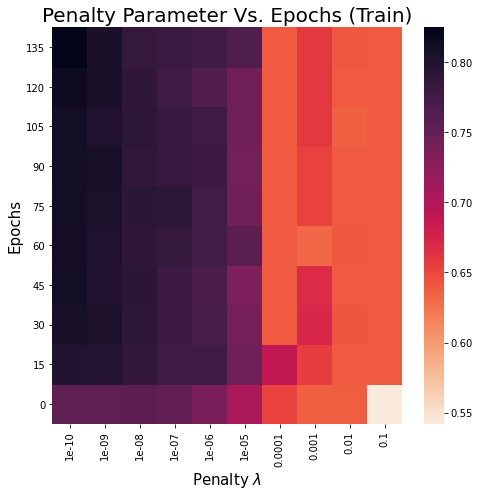

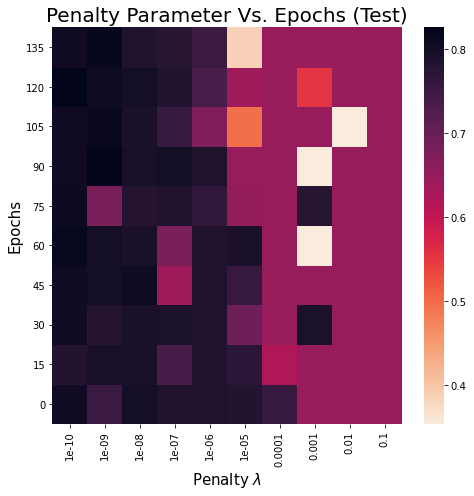

In [72]:
penalties = np.logspace(-10, -1, 10)
trains = []
tests = []
epochs = list(range(0,140,15))

for i in range(len(penalties)):
    lamb = learning_rates[i]
    print('Beginning training with a penalty of: '+str(lamb))
    neural = Keras_NN(hidden_layers=[120], out_layer=2, learning=0.3, regul=lamb, act_func='relu', proba=True)
    resultsNN = neural.fit(nX_train, nY_train, epochs=140, verbose=0, validation_split=0.2, shuffle=True)
    train_res = np.array(resultsNN.history['accuracy'])
    test_res = np.array(resultsNN.history['val_accuracy'])
    trains.append(train_res[epochs])
    tests.append(test_res[epochs])
    
trains = np.array(trains)
tests = np.array(tests)
epochs = np.array(epochs)
    
title = 'Penalty Parameter Vs. Epochs (Train)'
ylabel = 'Epochs'
xlabel = 'Penalty $\lambda$'
plot_heatmap(trains, title, xlabel, ylabel, x_values=np.round(penalties,10), y_values=epochs, x_rot=False, log_scale=False, fig_name='NN_penalty_var_train.png')

title = 'Penalty Parameter Vs. Epochs (Test)'
ylabel = 'Epochs'
xlabel = 'Penalty $\lambda$'
plot_heatmap(tests, title, xlabel, ylabel, x_values=np.round(penalties,10), y_values=epochs, x_rot=False, log_scale=False, fig_name='NN_penalty_var_test.png')

## 5. The architecture? Which one to use?

Don't worry. This is mostly how we know which architecture is the ideal. We play between the number of nodes in each layer and the number of hidden layers. There is a printing of each architecture tested so you can have an idea of how we vary this and which ones are we using...

Training for the following architecture of layers and nodes:  [10]
Training for the following architecture of layers and nodes:  [20]
Training for the following architecture of layers and nodes:  [40]
Training for the following architecture of layers and nodes:  [60]
Training for the following architecture of layers and nodes:  [80]
Training for the following architecture of layers and nodes:  [100]
Training for the following architecture of layers and nodes:  [120]
Training for the following architecture of layers and nodes:  [140]
Training for the following architecture of layers and nodes:  [10, 10]
Training for the following architecture of layers and nodes:  [20, 20]
Training for the following architecture of layers and nodes:  [40, 40]
Training for the following architecture of layers and nodes:  [60, 60]
Training for the following architecture of layers and nodes:  [80, 80]
Training for the following architecture of layers and nodes:  [100, 100]
Training for the following archit

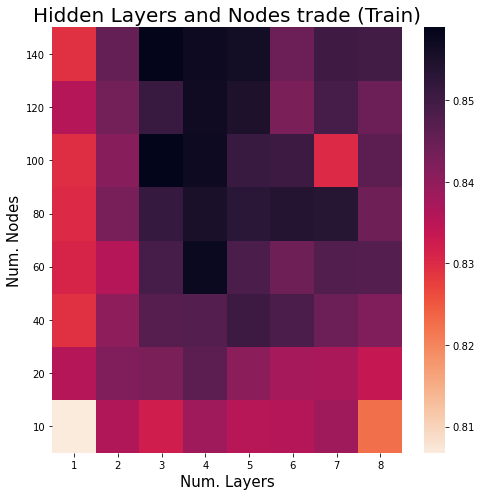

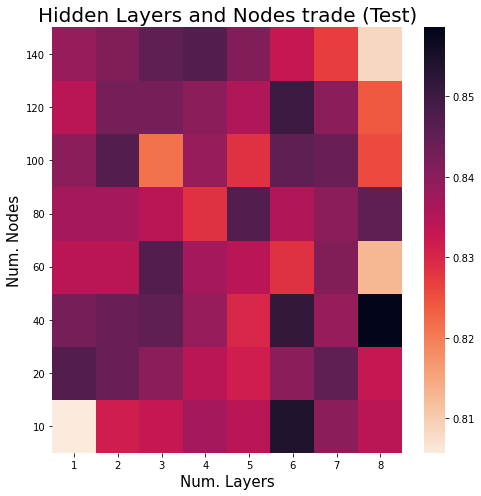

In [75]:
#Making the layers and nodes parameters to vary
layers = [1,2,3,4,5,6,7,8]
nodes = [10,20,40,60,80,100,120,140]
iterate = []
for lay in layers:
    min_iterate = []
    for n in nodes:
        min_iterate.append([n]*lay)
    iterate.append(min_iterate)
    
mtr_Acc = []
mer_Acc = []
    
for lay in iterate:
    tr_acc = []
    er_acc = []
    for nod in lay:
        print('Training for the following architecture of layers and nodes: ', nod)
        neural = Keras_NN(hidden_layers=nod, out_layer=2, learning=0.3, regul=0.0, act_func='relu', proba=True)
        resultsNN = neural.fit(nX_train, nY_train, epochs=350, verbose=0, validation_split=0.2, shuffle=True)
        train_res = np.array(resultsNN.history['accuracy'])[-1]
        test_res = np.array(resultsNN.history['val_accuracy'])[-1]
        tr_acc.append(train_res)
        er_acc.append(test_res)
    mtr_Acc.append(tr_acc)
    mer_Acc.append(er_acc)
    
trains = np.array(mtr_Acc)
tests = np.array(mer_Acc)
layers = np.array(layers)
nodes = np.array(nodes)
    
title = 'Hidden Layers and Nodes trade (Train)'
ylabel = 'Num. Nodes'
xlabel = 'Num. Layers'
plot_heatmap(trains, title, xlabel, ylabel, x_values=layers, y_values=nodes, x_rot=False, log_scale=False, fig_name='NN_layers_nodes_train.png')

title = 'Hidden Layers and Nodes trade (Test)'
ylabel = 'Num. Nodes'
xlabel = 'Num. Layers'
plot_heatmap(tests, title, xlabel, ylabel, x_values=layers, y_values=nodes, x_rot=False, log_scale=False, fig_name='NN_layers_nodes_test.png')

## 5. Time to test the NN model with real data!!

Up to this part we think we already made all our hyperparameters tunning to establish the best NN model to use because their performances were the best:
- Learning rate = 0.3
- Penalty = None
- Activation function = ReLU
- Epochs = 350
- Architecture = [ 100, 100, 100, 100 ]

Now lets try to use all this into a final model and see how it classifies complete known labeled data and new data unclassified. First we will train the best model and then we import the data to predict.

In [104]:
neural = Keras_NN(hidden_layers=[100, 100, 100, 100], out_layer=2, learning=0.3, regul=0.0, act_func='relu', proba=True)
neural.fit(nX_train, nY_train, epochs=350, verbose=0, validation_split=0.2, shuffle=True)

Lets see hows the clasification done compared to the real solution. This images were used for training, so this is a kind of a validation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[77.41541685  2.62740141]
 [ 8.55294774 11.404234  ]]
Precision of: 81.27515907025061
Sensitivity of: 57.14350927246791
Specifity of: 96.71750512178465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[79.52535502  5.10698871]
 [ 9.62978147  5.7378748 ]]
Precision of: 52.908686155913976
Sensitivity of: 37.33734475501675
Specifity of: 93.96567731726549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[36.85297387 10.12825987]
 [ 6.41431495 46.60445131]]
Precision of: 82.14740727688664
Sensitivity of: 87.90180269141412
Specifity of: 78.44190315449336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[41.674451   12.03463935]
 [ 8.52836571 37.76254395]]
Precision of: 75.83269062796187
Sensitivity of: 81.5765864824746
Specifity of: 77.59291905787026


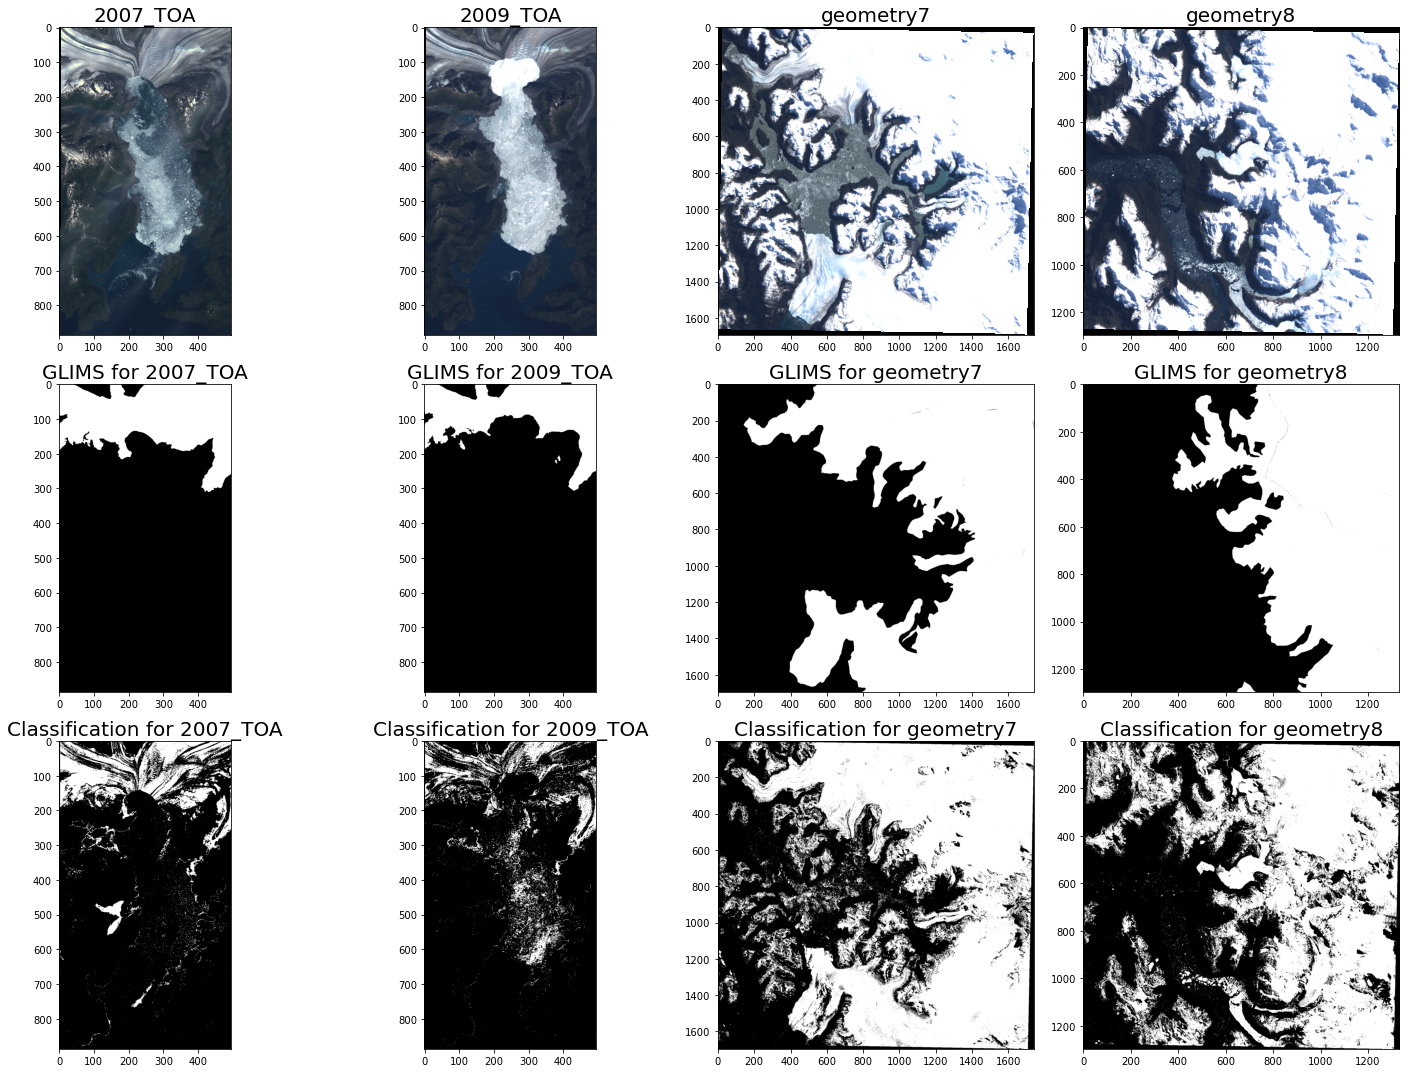

In [109]:
dirc = ['2007_TOA','2009_TOA','geometry7','geometry8']

fig, ax = plt.subplots(3,4, figsize=(20,15))

for i in range(4):
    lk = [r'data/'+dirc[i]+'/red.tif', r'data/'+dirc[i]+'/green.tif', r'data/'+dirc[i]+'/blue.tif', r'data/'+dirc[i]+'/glimsRast.tif']
    original = np.stack([rt.open(lk[0]).read(1), rt.open(lk[1]).read(1), rt.open(lk[2]).read(1)], axis=2)
    
    sample = pre_processing(r'data/'+dirc[i], stack_axis=2)
    sample[np.isnan(sample)] = 0.0
    shape_s =  sample.shape
    sample = sample.reshape(shape_s[0]*shape_s[1],shape_s[2])
    
    target = rt.open(lk[3]).read(1)
    shape_t = target.shape
    target[target != 0.0] = 1.0
    target = target.reshape(shape_t[0]*shape_t[1],1)
    
    result = decoder(neural.predict(sample))
    
    tn, fp, fn, tp = confusion_matrix(target,result,labels=[0,1]).ravel()
    print(confusion_matrix(target,result, normalize='all', labels=[0,1])*100)
    print('Precision of: '+str( tp/(tp+fp)*100 ))
    print('Sensitivity of: '+str( tp/(tp+fn)*100 ))
    print('Specifity of: '+str( tn/(tn+fp)*100 ))
    
    ax[0,i].imshow(2*original)
    ax[0,i].set_title(dirc[i], fontsize=20)
    ax[1,i].imshow(target.reshape(shape_t), cmap='gray')
    ax[1,i].set_title('GLIMS for '+dirc[i], fontsize=20)
    ax[2,i].imshow(result.reshape(shape_t), cmap='gray')
    ax[2,i].set_title('Classification for '+dirc[i], fontsize=20)
    
fig.tight_layout()
name = 'NN_predictions_sol.png'
plt.savefig('figures/'+name)

Now lets see how it performs with uknown images for glacier classification. Thus this means that we don't know the solution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


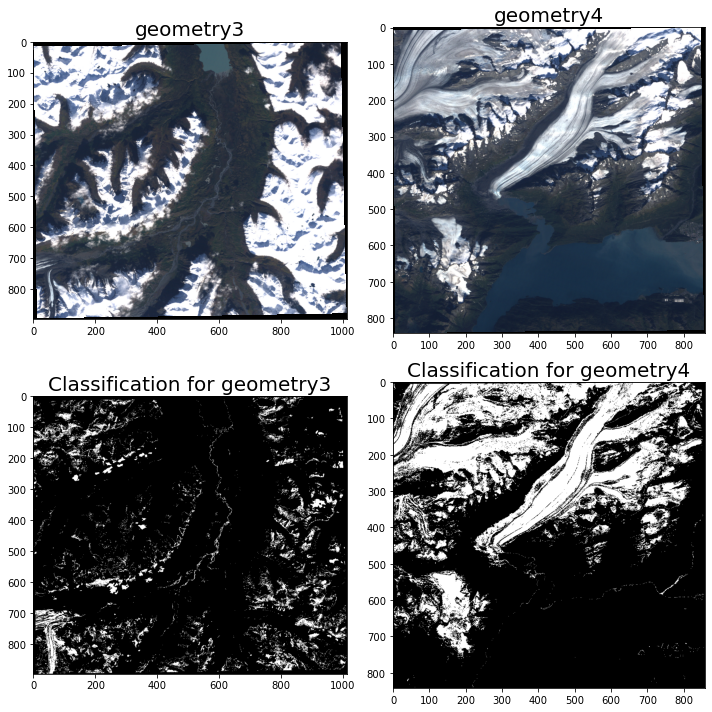

In [112]:
dirc = ['geometry3','geometry4']

fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in range(2):
    lk = [r'data/'+dirc[i]+'/red.tif', r'data/'+dirc[i]+'/green.tif', r'data/'+dirc[i]+'/blue.tif']
    original = np.stack([rt.open(lk[0]).read(1), rt.open(lk[1]).read(1), rt.open(lk[2]).read(1)], axis=2)
    
    sample = pre_processing(r'data/'+dirc[i], stack_axis=2)
    sample[np.isnan(sample)] = 0.0
    shape_s =  sample.shape
    sample = sample.reshape(shape_s[0]*shape_s[1],shape_s[2])
    
    #There is no targets for this ones! We are going blind :D
    #target = rt.open(lk[3]).read(1)
    #shape_t = target.shape
    #target[target != 0.0] = 1.0
    #target = target.reshape(shape_t[0]*shape_t[1],1)
    
    result = decoder(neural.predict(sample))
    
    ax[0,i].imshow(2*original)
    ax[0,i].set_title(dirc[i], fontsize=20)
    ax[1,i].imshow(result.reshape(shape_s[0], shape_s[1]), cmap='gray')
    ax[1,i].set_title('Classification for '+dirc[i], fontsize=20)
    
fig.tight_layout()
name = 'NN_predictions_NONEsol.png'
plt.savefig('figures/'+name)

## #.References
- Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.